In [17]:
# Import excel spreadsheet to pandas data frame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

In [5]:
# Define path the folder and phase excel file from RRP
directory = '/Users/sean/Documents/FJ_round2/'  # job folder
file_phase='PhaseTableReport(1).xlsx' # phase report from RRP
file_log = 'log-2022Dec02.proc.concat.1s_clean.csv' # log file from log cleaner
headerRow = 1 # row number of first phase in phase report

In [6]:
# import using read_excel, using headercolumn as columnnames
phases_in = pd.read_excel(directory+file_phase, header=headerRow-1)
phases_in = phases_in.dropna(subset=['StartTime']) # remove excess rows


In [7]:
phases_in.columns

Index(['Type', 'Tack', 'StartTime', 'Duration', 'Sails', 'RaceLeg', 'Subject',
       'Comments', 'Density', 'TWS', 'TWA', 'Perf', 'Pol%', 'Vmg%', 'TWS_Bin',
       'TWA_Bin', 'BSP_Bin', 'Dist (Nm)', 'BSP', 'AHEEL', 'AWA', 'TRIM'],
      dtype='object')

In [8]:
# convert excel time to datetime and round to nearest second
try:
    log_in = pd.read_csv(directory+file_log, low_memory=False) # import log using read_csv
    timeHeader = input("Enter column for time stamp\n"+ str(list(log_in.columns)))
    for var in list(log_in): # iterate over each variable in the log file
        log_in[var] = pd.to_numeric(log_in[var], errors='coerce') # change variable type to numeric
        log_in[var] = log_in[var].astype('float') # chnage data type to float
    log_in[timeHeader] = pd.to_datetime(log_in[timeHeader], unit='D', origin='1899-12-30').round('1s') # make the timestamps a datetime type
except:
    print("error loading log file")

error loading log file


In [16]:
# convert excel time to datetime and round to nearest second
try:
    log_in = pd.read_csv(directory+file_log, low_memory=False) # import log using read_csv
    timeHeader = input("Enter column for time stamp\n"+ str(list(log_in.columns)))
    for var in list(log_in): # iterate over each variable in the log file
        log_in[var] = pd.to_numeric(log_in[var], errors='coerce') # change variable type to numeric
        log_in[var] = log_in[var].astype('float') # chnage data type to float
    log_in[timeHeader] = pd.to_datetime(log_in[timeHeader], unit='D', origin='1899-12-30').round('1s') # make the timestamps a datetime type
except:
    print("error loading log file")

In [10]:
# set categorical variable types
categoricalVariables = ['Sails','Tack', 'TWS_Bin', 'TWA_Bin']
dropped = []
for var in categoricalVariables: # iterate over all categorical variables
    phases_in[var] = phases_in[var].astype('category') # change type to catagorical
    catCount = phases_in.groupby(var).size() # find total number of each category
    catCount = catCount/sum(catCount) # calculate category size as fraction of all observations
    drop = catCount[catCount < 0.01].index # identify cases that represent less than 1%
    phases_in[var] = phases_in[var].cat.remove_categories(drop) # drop cases which represent less than 1%
    dropped.append(drop)
## Print dropped catagories
for i in range(len(dropped)): #iterate over each entry in dropped list
    if len(dropped[i]) > 0: #check if any indecies are present
        print("The following categories where dropped from "+str(dropped[i].name)+"\n")
        for n in range(len(dropped[i])): # iterate over each dropped entry
            print(str(dropped[i][n])) # print each dropped category


The following categories where dropped from TWS_Bin

22


In [11]:
## rename categories in categorical variables
for var in categoricalVariables:
    print("The variable "+str(var)+" contains the following catagories")
    for n in range(len(phases_in[var].cat.categories)):
        print(phases_in[var].cat.categories[n])
    print("-------------------------------- \n")
### to be finished
#renameDict = {'dayNight':['Night','Day']}
#phases_in['DayNight'].cat.rename_categories(['Night', 'Day'], inplace=True) # change Daynight from 0/1 to night/Day

The variable Sails contains the following catagories
A1.5-C
A1.5-D
A2-D
J1-B
J1.5-D
J2.5-C
-------------------------------- 

The variable Tack contains the following catagories
Port/Dn
Port/Rch
Port/Up
Stbd/Dn
Stbd/Rch
Stbd/Up
-------------------------------- 

The variable TWS_Bin contains the following catagories
6
8
10
12
14
16
18
20
-------------------------------- 

The variable TWA_Bin contains the following catagories
35
40
45
50
55
120
130
140
150
160
170
-------------------------------- 



In [13]:
## create custom bins
phases_in['BspPolBin'] = pd.cut(phases_in['Pol%'], bins=[0, 90, 98, 105, 200], labels=['<90', '90 to 98', '98 to 105', '> 105'])
phases_in['VmgPercBin'] = pd.cut(phases_in['Vmg%'], bins=[0, 85, 95, 105, 200], labels=['<90', '90 to 98', '98 to 105', '> 105'])
phases_in['awaBin'] = pd.cut(phases_in['AWA'], bins=list(range(49,141,2)), labels=list(range(50,140,2)))
phases_in['heelBin'] = pd.cut(abs(phases_in['AHEEL']), bins=list(np.arange(0.5,29.5,1)), labels=list(range(1,29)))
phases_in['BspBin'] = pd.cut(phases_in['BSP'], bins=list(np.arange(3.9,25.1,0.2)), labels=list(np.arange(4,25.1,0.2)))
phases_in['Mode'] = pd.cut(phases_in['TWA'], bins=[0,30,65,120,160,180], labels=['NAHigh','UpWind','Reaching','DownWind','NALow'])
phases_in['TwsBin'] = pd.cut(phases_in['TWS'], bins=list(np.arange(0.5,34.5,1)), labels=list(range(1,34,1)))

#phases_in['TwsBin'] = pd.cut(phases_in['TWS'], bins=list(range(1,34,2)), labels=list(range(2,34,2)))
phases_in['TwaBin'] = pd.cut(phases_in['TWA'], bins=list(range(1,180,2)), labels=list(range(2,180,2)))

In [15]:
pd.cut(abs(phases_in['AHEEL']), bins=list(np.arange(0.5,29.5,1)), labels=list(range(1,29)))

0       3
1       3
2       2
3       2
4       1
       ..
547    13
548    12
549    11
550    11
551    13
Name: AHEEL, Length: 552, dtype: category
Categories (28, int64): [1 < 2 < 3 < 4 ... 25 < 26 < 27 < 28]

In [33]:
phases_in['HEEL']

0      -5.6
1       -11
2     -11.4
3      -8.6
4     -11.8
       ... 
925   -29.1
926   -26.6
927   -22.3
928   -25.3
929   -24.7
Name: HEEL, Length: 930, dtype: object

In [16]:
## Percentile graphs
# make this easy to select metric and variable
PGVar = 'heelBin'
PGMetric = 'BSP_trg%'
PGMode = 'UpWind'
filter_remove = {}


PGdataFrame = phases_in[phases_in['Mode']==PGMode]
for key in filter_remove:
    for filter in filter_remove[key]:
        PGdataFrame = PGdataFrame[PGdataFrame['key']!=filter]

PGdataFrame = PGdataFrame[[PGVar,PGMetric,'TwsBin']].dropna()
PGarray = PGdataFrame.to_numpy()


for tws in list(np.unique(PGarray[:,2])):
    PGarray_tws = PGarray[np.where(PGarray==tws)[0],0:2]
    if len(list(np.unique(PGarray_tws[:,0]))) < len(list(PGarray_tws[:,0])):
        percentile_1 = []
        percentile_2 = []
        percentile_3 = []
        percentile_4 = []
        percentile_5 = []
        bins_line = []
        bins_point = []
        points = []
        bins = np.unique(PGarray_tws[:,0])
        for bin in bins:
            sample = PGarray[np.where(PGarray_tws[:,0]==bin),1:2][0]
            if len(sample) > 1:
                bins_line.append(bin)
                score = np.percentile(sample,[50,75,90,95,99])
                percentile_1.append(score[0])
                percentile_2.append(score[1])
                percentile_3.append(score[2])
                percentile_4.append(score[3])
                percentile_5.append(score[4])
            else:
                bins_point.append(bin)
                points.append(sample[0])

        plt.plot(bins_point,points,'bo', alpha=0.5)
        plt.fill_between(
            bins_line,
            percentile_5,
            percentile_4,
            color='blue',
            alpha=0.6)
        plt.fill_between(
            bins_line,
            percentile_4,
            percentile_3,
            color='green',
            alpha=0.75)
        plt.fill_between(
            bins_line,
            percentile_3,
            percentile_2,
            color='orange',
            alpha=0.5)
        plt.fill_between(
            bins_line,
            percentile_2,
            percentile_1,
            color='red',
            alpha=0.3)
        plt.xlim([min(bins_line),max(bins_line)])
        plt.title(str(PGVar)+' Percentile Graph @ TWS = '+str(tws))
        plt.savefig(str(tws)+"_"+str(PGVar)+"PercentileGraph.png") # save plot
        plt.clf() # close plot figure so it is not over plotted

KeyError: "['BSP_trg%'] not in index"

In [176]:
#create time series graphs
time_seriesVars = ['BSP', 'TWA','TWS','TWD'] # variables to create time series of
for var in time_seriesVars: # loop over variables
    plt.figure(figsize=(20,2)) # make elongated figure
    timeSeries = sns.lineplot(data=log_in, x=timeHeader, y=var, lw=0.5) # create time series plot
    timeSeries.set_title(var+' Vs time') # add title
    sns.despine() # remove outline box
    plt.savefig(var+'_timeSeries.png') # save as .png
    plt.clf() # close plot figure so it is not over plotted

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

In [179]:
#create frequency distribution plots of relevant continous variables
densityVars = ['BSPpol%', 'VMG%' ] # select variables to plot
for var in densityVars: # loop over each variable in list of variables
    overallDensity = sns.histplot(data=phases_in, x=var, kde=True) # create seaborn plot
    overallDensity.set_title(var+' Freqency Count') # add title
    sns.despine() # remove outline box
    plt.savefig(var+'_Freqency Count') # save as .png
    plt.clf() # close plot figure so it is not over plotted


<Figure size 432x288 with 0 Axes>

In [39]:
#create class count bar plots for categorical variables
countVars = ['Sails', 'TwaBin', 'TwsBin', 'Tack'] # Select relevant variables

for var in countVars: # loop over var in variables
    overallCount = sns.countplot(y=var, data=phases_in, color="c") # create seaborne plot
    overallCount.set_title(var+' Category Count') # set title
    sns.despine() # remove outline box
    plt.savefig(str(var)+'_CategoryCount') # save plot
    plt.clf() # close plot figure so it is not over plotted


<Figure size 432x288 with 0 Axes>

In [184]:
# create hist plot of TWS and TWA
TwaTws_hist = sns.histplot(x=log_in.TWA.abs(), y=log_in.TWS.abs())
TwaTws_hist.set_title('Frequency of TWA vs TWS')
sns.despine
plt.savefig("TwsTwa_hist.png")
plt.clf()
## Add legend to this plot.

<Figure size 432x288 with 0 Axes>

In [17]:
## P Test Phase comparison
targetVariable = input("Phase analysis contains the following categorical variables \n"+str(phases_in.select_dtypes(include=['category']).columns.tolist())+"\n Please enter the target variable")
performanceMetric = input("Please enter the desired performance metric")
sailingMode = input("Please enter the sailing mode to analyse\n"+str(phases_in['Mode'].cat.categories))
binWidth_tws = int(input("Please enter the TWS bin width"))
pTest_df = phases_in[[targetVariable, 'TWS', 'TWA', performanceMetric, 'Mode']]
pTest_df = pTest_df[pTest_df['Mode']==sailingMode]

newLabels = {}
for label in pTest_df[targetVariable].cat.categories.tolist():
    newLab = input("Please enter simple Category label for \n"+str(label)+"\nEntered new labels are \n"+str(np.unique(newLabels.values()))+"\n Enter NA to drop category")
    newLabels.update({label:newLab})
pTest_df[targetVariable] = pTest_df[targetVariable].map(newLabels).astype('category')
pTest_df = pTest_df[pTest_df[targetVariable]!='NA']

tws_cuts = list(range(math.floor(pTest_df['TWS'].min()), math.ceil(pTest_df['TWS'].max()), int(binWidth_tws)))
if binWidth_tws == 1:
    tws_labels = list(range(math.floor(pTest_df['TWS'].min()), math.ceil(pTest_df['TWS'].max()-1), binWidth_tws))
else:
    tws_labels = list(range(math.floor(pTest_df['TWS'].min())+1, math.ceil(pTest_df['TWS'].max()-1), binWidth_tws))
pTest_df['TwsBin'] = pd.cut(pTest_df['TWS'], bins=tws_cuts, labels=tws_labels)
bin_count = pTest_df.groupby(['TwsBin']).size()
twsBins_kept = []
for i in range(len(bin_count)):
    if bin_count.values[i] < 10:
        pTest_df = pTest_df[pTest_df['TwsBin']!= bin_count.index.categories[i]]
    elif any(np.asarray(pTest_df[pTest_df['TwsBin']==bin_count.index.categories[i]].groupby(targetVariable).size().tolist())==sum(pTest_df[pTest_df['TwsBin']==bin_count.index.categories[i]].groupby(targetVariable).size().tolist())):
        pTest_df = pTest_df[pTest_df['TwsBin']!= bin_count.index.categories[i]]
    else:
        twsBins_kept.append(bin_count.index.categories[i])
pTest_df = pTest_df.dropna()
toDrop = {}
for tws in twsBins_kept:
    sail = []
    sail = input("Bin count for sail in "+str(tws)+"\n"+
          str(pTest_df[pTest_df['TwsBin']==tws].groupby(targetVariable).size())+"\n"+
          "Enter sail to drop, seperated by ;")
    sail = sail.split(';')
    if len(sail) > 0:
        toDrop.update({tws:sail})

for tws in twsBins_kept:
    testFrame = pTest_df[pTest_df['TwsBin']==tws]
    testFrame = testFrame[[targetVariable,performanceMetric]].dropna()
    testCategories = np.unique(testFrame[targetVariable].tolist())
    drop = np.asarray(toDrop[tws])
    testCategories = list(set(testCategories)-set(drop))
    testFrame = testFrame[testFrame[targetVariable].isin(testCategories)]
    testPlot = sns.displot(testFrame, x=performanceMetric, hue=targetVariable, kind='kde')
    testPlot.set(title ='TWS='+str(tws))
    sns.despine
    plt.savefig(str(tws))
    plt.clf()


ValueError: invalid literal for int() with base 10: ''

In [70]:
## Nav polar finder
sailingMode = input("Please enter the sailing mode to analyse\n"+str(phases_in['Mode'].cat.categories))
polarFinder_df = phases_in[phases_in['Mode']==sailingMode][['TWS','TWA','BSP']]

In [71]:
polarFinder_df['TwsBin'] = pd.cut(polarFinder_df['TWS'], bins=list(np.arange(0.5,34.5,1)), labels=list(range(1,34,1)))

In [72]:
bin_count = polarFinder_df.groupby('TwsBin').size()


In [73]:
twsBins_kept = []
for i in range(len(bin_count.values)):
    if bin_count.values[i] > 10:
        twsBins_kept.append(bin_count.index.categories[i])


In [74]:
percentile_25 = []
percentile_50 = []
percentile_75 = []
for tws in twsBins_kept:
    scores= np.percentile(polarFinder_df[polarFinder_df['TwsBin']==tws]['TWA'],[25,50,75])
    percentile_25.append(scores[0])
    percentile_50.append(scores[1])
    percentile_75.append(scores[2])

In [75]:
plt.plot(twsBins_kept,percentile_25)
plt.plot(twsBins_kept,percentile_50)
plt.plot(twsBins_kept,percentile_75)
plt.xticks(range(4,22,1))
plt.savefig('downNav')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [24]:
twsBins_kept

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [19]:
# detail variables to keep for ballast analysis
ballast_variables = ['Sails','TwsBin','TwaBin','WaterBallast', 'BSPpol%', 'VMG%', 'HEEL_TRG', 'HEEL_DELTA', 'HEEL']
# create new DF to show class balance and count for water ballast
ballast_bal = phases_in[ballast_variables] 
# group phases by TWS/TWA and count 'WaterBallast' class freqnecies
ballast_bal = phases_in.groupby(['TwsBin','TwaBin'], as_index=False).WaterBallast.value_counts(normalize=True) 
# drop NA's and reset index
ballast_bal = ballast_bal.loc[ballast_bal['WaterBallast'] == 'Empty'].dropna().reset_index() 
# rescale so as 0 and 1 are the same
ballast_bal['Imbalance'] = abs(0.5 - ballast_bal['proportion']) 
# count the number of entries in each bin
ballast_bal['count'] = phases_in.groupby(['TwsBin','TwaBin'], as_index=False).WaterBallast.count().WaterBallast 

<AxesSubplot:xlabel='TwaBin', ylabel='TwsBin'>

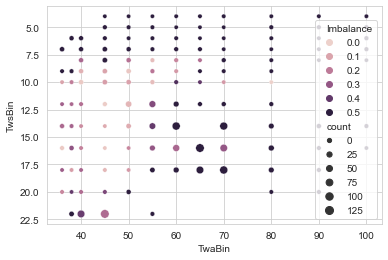

In [20]:
sns.scatterplot(x='TwaBin', y='TwsBin', hue='Imbalance', size='count', data=ballast_bal)

In [21]:
ballast_test_TwsBin = ballast_bal.loc[((ballast_bal['Imbalance'] < 0.2) & (ballast_bal['count'] > 10))].TwsBin.reset_index()
ballast_test_TwsBin = list(ballast_test_TwsBin['TwsBin'])
ballast_test_TwaBin = ballast_bal.loc[((ballast_bal['Imbalance'] < 0.2) & (ballast_bal['count'] > 10))].TwaBin.reset_index()
ballast_test_TwaBin = list(ballast_test_TwaBin['TwaBin'])


In [22]:
print(range(0,))
print(ballast_test_TwaBin)
print(ballast_test_TwsBin)


range(0, 0)
[40, 45, 50, 40, 45, 50, 55, 45, 50, 50, 36]
[9, 9, 9, 10, 10, 10, 10, 12, 12, 14, 16]


In [23]:
#for i in range(len(ballast_test_TwsBin)):
twa = ballast_test_TwaBin[2]
tws = ballast_test_TwsBin[14]
ballast_test = phases_in[((phases_in.TwaBin == twa) & (phases_in.TwsBin == tws))]


IndexError: list index out of range

In [24]:
ballast_test = ballast_test[ballast_variables]
full_BSPpol = ballast_test[ballast_test.WaterBallast == 'Full']
empty_BSPpol = ballast_test[ballast_test.WaterBallast == 'Empty']
print(len(full_BSPpol))
print(len(empty_BSPpol))
tTest = stats.ttest_ind(full_BSPpol['VMG%'], empty_BSPpol['VMG%'])
test_plot = sns.displot(ballast_test, x='VMG%', hue='WaterBallast', kind='kde', palette = ['red','blue'] )
avg = ballast_test.groupby(['WaterBallast']).mean()['VMG%']
plt.axvline(x=avg[0], color = 'red')
plt.axvline(x=avg[1], color = 'blue')
test_plot.set(title = 'TWA='+str(twa)+' TWS='+str(tws)+ ', p-value='+str(tTest[1])) # set title
sns.despine

plt.savefig(str(i))
plt.clf()

NameError: name 'ballast_test' is not defined

In [25]:
ballast_test


NameError: name 'ballast_test' is not defined

In [91]:
twa = 130
tws = 6
ballast_test = phases_in[((phases_in.TwaBin == twa) & (phases_in.TwsBin == tws))]
ballast_test = ballast_test[ballast_variables]

In [92]:
test

NameError: name 'test' is not defined

/var/folders/1y/_719kcl11vggrmnzn4bbqdzw0000gn/T/ipykernel_4938/1982660045.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']


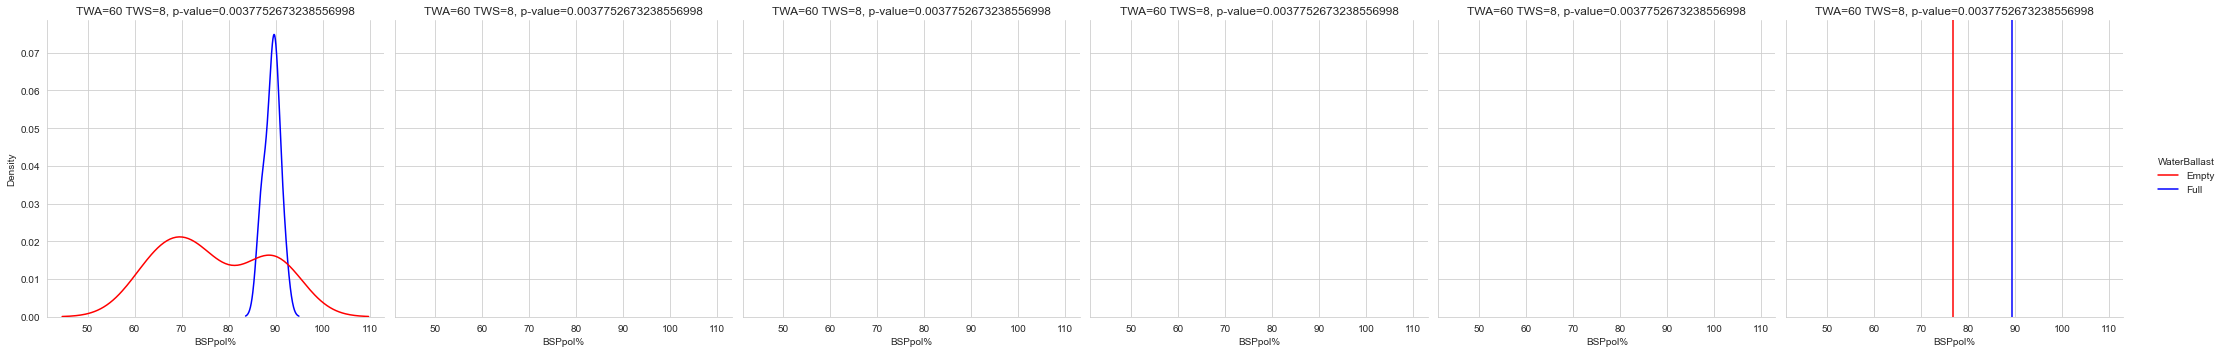

In [25]:
test_plot = sns.displot(ballast_test, x='BSPpol%', hue='WaterBallast', kind='kde', palette = ['red','blue'], col='Sails' )
avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']
plt.axvline(x=avg[0], color = 'red')
plt.axvline(x=avg[1], color = 'blue')
test_plot.set(title = 'TWA='+str(twa)+' TWS='+str(tws)+ ', p-value='+str(tTest[1])) # set title

In [198]:
ballast_test.groupby(['WaterBallast']).mean()['BSPpol%'][1]

92.02083333333333

In [197]:
ballast_test.groupby(['WaterBallast']).mean().index

CategoricalIndex(['Empty', 'Full'], categories=['Empty', 'Full'], ordered=False, dtype='category', name='WaterBallast')